<a href="https://colab.research.google.com/github/wf-yamaday/machine-learning/blob/master/%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E3%81%AE%E6%95%99%E7%A7%91%E6%9B%B8/section5_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 機械学習
## 教師あり学習・回帰
回帰とは，入力に対して連続した数値を対応づける問題のことを指す．
このノートでは，年齢xと身長tのデータセットで年齢xを入力変数に身長tを目標変数としてデータセットにない年齢xに対して身長tの予測を行う．

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# データ生成
np.random.seed(seed=1)
X_min = 4 #年齢の下限（表示用）
X_max = 30 # 年齢の上限（表示用）
X_n = 16 #データセットの数
X = 5 + 25 * np.random.rand(X_n)
Prm_c = [170,108,0.2]
T = Prm_c[0]-Prm_c[1]*np.exp(-Prm_c[2]*X)+ 4*np.random.randn(X_n) #A
np.savez('ch5_data.npz',X=X,X_min=X_min,X_max=X_max,X_n=X_n,T=T)

上のプログラムでは，16人分の年齢Xをランダムに決定している．
AによってXからTを決定している．
以下ではXの中身とTの中身を確認してみる．

In [7]:
# Xの中身の確認
print(X)
print(np.round(X,2))
# Tの中身の確認
print(np.round(T,2))

[15.42555012 23.00811234  5.00285937 12.55831432  8.66889727  7.30846487
  9.65650528 13.63901818 14.91918686 18.47041835 15.47986286 22.13048751
 10.11130624 26.95293591  5.68468983 21.76168775]
[15.43 23.01  5.   12.56  8.67  7.31  9.66 13.64 14.92 18.47 15.48 22.13
 10.11 26.95  5.68 21.76]
[170.91 160.68 129.   159.7  155.46 140.56 153.65 159.43 164.7  169.65
 160.71 173.29 159.31 171.52 138.96 165.87]


これらXとTを散布図にプロットしてみる．

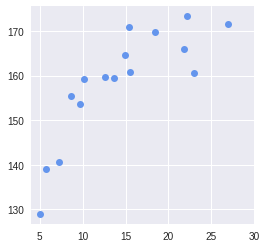

In [8]:
plt.figure(figsize=(4,4))
plt.plot(X,T,marker='o',linestyle='None',markeredgecolor='black',color='cornflowerblue')
plt.xlim(X_min,X_max)
plt.grid(True)
plt.show()

## 直線モデル
このデータセットから回帰直線を求める．  
$$ y(x)=w_0x+w_1$$
具体的にはデータセットから$w_0$と$w_1$の値を求めることを行う．  
そのためには**二乗誤差関数**を用いる．誤差Jは以下の式で定義する．
$$
J = \frac{1}{N}\sum_{n=0}^{N-1}{(y_n - t_n)^2}
$$
これは平均二乗誤差(mean squire error)と呼ばれる．

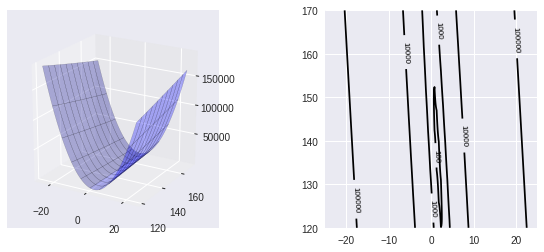

In [11]:
from mpl_toolkits.mplot3d import Axes3D
# 平均誤差関数
def mse_line(x, t, w):
  y = w[0]*x + w[1]
  mse = np.mean((y - t)**2)
  return mse

# 計算
xn = 100 # 等高線の解像度
w0_range = [-25, 25]
w1_range = [120, 170]
x0 = np.linspace(w0_range[0],w0_range[1],xn)
x1 = np.linspace(w1_range[0],w1_range[1],xn)
xx0, xx1 = np.meshgrid(x0, x1)
J = np.zeros((len(x0), len(x1)))
for i0 in range(xn):
  for i1 in range(xn):
    J[i1, i0] = mse_line(X, T, (x0[i0], x1[i1]))

plt.figure(figsize=(9.5,4))
plt.subplots_adjust(wspace=0.5)

ax = plt.subplot(1,2,1,projection='3d')
ax.plot_surface(xx0, xx1, J, rstride=10,cstride=10,alpha=0.3,color='blue', edgecolor='black')
ax.set_xticks([-20,0,20])
ax.set_yticks([120,140,160])
ax.view_init(20,-60)

plt.subplot(1,2,2)
cont = plt.contour(xx0,xx1,J,30,colors='black',levels=[100,1000,10000,100000])
cont.clabel(fmt='%1.0f',fontsize=8)
plt.grid(True)
plt.show()

上図，左のグラフにおいて-20~20の軸が$w_0$を動かした時の$J$の変化，120~160の軸が$w_1$の変化を表している．  
このことから，$w_0$方向での変化に対して$J$が大きく変化することがわかる．  
そして右のグラフから誤差$J$が最小となる値を予想することができる．この場合は$w_0 = 5, w_1 = 135$で最小値をとっていると考えられる．

## パラメータを求める（勾配法）
$J$が最も小さくなる$w_0$と$w_1$を求める方法を考える．  
最も単純な方法は **勾配法（最急降下法, steepest descent method）**である．  
勾配法では$w_0$と$w_1$に対して$J$の地形をイメージし，初期位置となる$w_0$と$w_1$を適当に決める．これは$J$上の1点に対応しており，この点での傾きを調べることで，$J$が最も減少する方向へ$w_0$と$w_1$を進める．この操作を繰り返し，最終的に$J$が最も小さくなる点での$w_0$と$w_1$を求めることができる．  
ここで使うのは**偏微分**です．$J$を$w_0$と$w_1$で偏微分したベクトル$[\frac{\partial J}{\partial w_0},\frac{\partial J}{\partial w_1}]^T$で表される．これを$J$の勾配（グラディエント）と呼び，$\nabla wJ$と表す．
$$
Jの勾配: \nabla wJ = [\frac{\partial J}{\partial w_0},\frac{\partial J}{\partial w_1}]^T
$$
※$\nabla (ナブラ)$とはベクトル演算子の一つ
$J$を最小にするには，$J$の勾配の反対方向$-\nabla wJ = -[\frac{\partial J}{\partial w_0}, \frac{\partial J}{\partial w_!}]^T$に進んで行けば良いことになります．  
$w$の更新方法を**学習則**と呼び，行列表記で表すと，
$$
 w(t+1) = w(t) -\alpha \nabla _wJ |_{w(t)}
$$
となる．$\nabla wJ$は$w$の関数になり，この$w$に現在の$w$の値$w(t)$を代入した値を$\nabla wJ | _{w(t)}$と表している．
このベクトルが今いる地点$w(t)$での勾配を表しており，$\alpha$は**学習率**と呼ばれる正の値をとるパラメータで$w$の更新の幅を調節する役割を持つ．大きいほど更新は大きくなるが，収束が不安定になるため適度に小さくする必要がある．

学習則を成分表示で表す．
$$
w_0(t+1) = w_0(t) - \alpha \frac{\partial{J}}{\partial{w_0}} |_{w_o(t),w_1(t)} \\
w_1(t+1) = w_1(t) - \alpha \frac{\partial{J}}{\partial{w_1}} |_{w_o(t),w_1(t)} 
$$
この偏微分を具体的に計算すると以下のようになる．
$$
J = \frac{1}{N} \sum_{n=0}^{N-1} (y_n-t_n)^2 = \frac{1}{N} \sum_{n=0}^{N-1}(w_0x_n+w_1-t_n)^2  \\
$$
$w_0$に関する偏微分に連鎖律（チェーンルール）を用いると \\
$$
\frac{\partial J}{\partial w_0} = \frac{2}{N} \sum_{n=0}^{N-1}(w_0x_n+w_1-t_n)x_n = \frac{2}{N} \sum_{n=0}^{N-1}(y_n-t_n)x_n \\
$$
となる．同様に$w_1$に対して \\
$$
\frac{\partial J}{\partial w_1} = \frac{2}{N} \sum_{n=0}^{N-1}(w_0x_n+w_1-t_n) = \frac{2}{N} \sum_{n=0}^{N-1}(y_n-t_n) 
$$
よって学習則は，
$$
w_0(t+1) = w_0(t) - \alpha\frac{2}{N} \sum_{n=0}^{N-1}(y_n-t_n)x_n \\
w_1(t+1) = w_1(t) - \alpha\frac{2}{N} \sum_{n=0}^{N-1}(y_n-t_n)  
$$
と表される．